In [2]:
# !pip install dask[dataframe]
# !sudo apt-get install graphviz graphviz-dev
# !sudo apt-get install build-essential
# !pip install pygraphviz pydot
# !pip install dowhy==0.8

In [3]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# import graphviz

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
dowhy.__version__

'0.8'

In [5]:
earnings_data = pd.read_csv('./data/ml_earnings.csv')
earnings_data.head(5)

,age,took_a_course,earnings
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [6]:
earnings_data.shape

(200, 3)

# Biased or Naive Estimate on Taking a course on Earnings

In [7]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

you can see that for some age groups
(for instance, 36 or 38), there are observations only for one of the values of the treatment. This means
that we won’t be able to compute the exact effects for these groups. We’ll leave it to our matching
estimator to handle this



let’s compute the naïve estimate of the causal effect of training
on earnings using the treatment and control group means

In [8]:
took_course_mean = earnings_data.groupby(['took_a_course'])['earnings'].mean()
took_course_mean

,earnings
took_a_course,
False,140680.508065
True,147376.078947


In [9]:
treatment_avg = took_course_mean.loc[True,]
control_avg = took_course_mean.loc[False,]
naive_att = treatment_avg - control_avg
naive_att

6695.570882852306

Naive estimate suggest that taking course increase the earnings by 6695 USD

# Unbiased estimate of effect on taking on course on earnings using approximate matching estimate

### Step #1: representing the problem as a graph

In [10]:
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

In [11]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [12]:
# Instantiate the CausalModel
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)

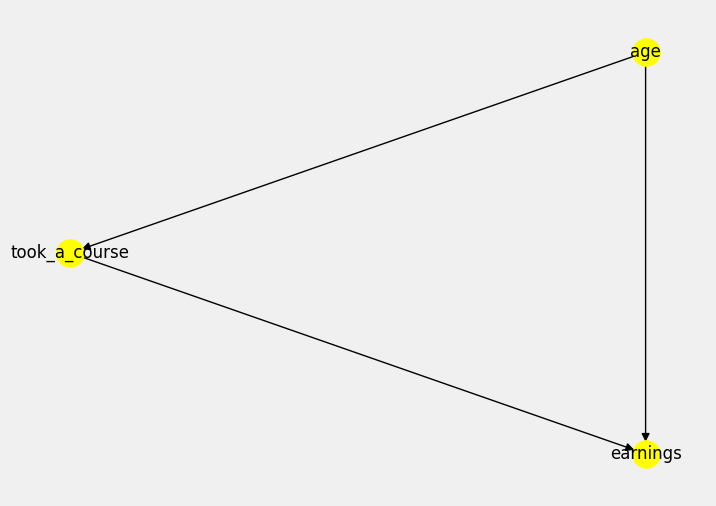

In [13]:
model.view_model()

### Step 2 – getting the estimand

In [14]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 3 – computing the effect

In [15]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

distance_matching


Let's break down the components:
`estimate = model.estimate_effect(...)`: This calls the `estimate_effect` method of the `CausalModel` object, which is responsible for computing the causal effect.
`identified_estimand=estimand`: This specifies the estimand that was previously identified using the `identify_effect` method. The estimand defines the target causal quantity we want to estimate (e.g., average treatment effect).
`method_name='backdoor.distance_matching'`: This specifies the estimation method to be used. In this case, it's a backdoor adjustment using distance matching. This means we're trying to estimate the causal effect by comparing treated and control units that are similar in terms of their observed covariates (confounders).
`target_units='ate'`: This indicates that we want to estimate the average treatment effect (ATE), which is the overall causal effect of the treatment on the outcome across all units in the population.

`method_params={'distance_metric': 'minkowski', 'p': 2'}`: This provides specific parameters for the distance matching method.
- `distance_metric='minkowski'` specifies the metric used to calculate the distance between units. Minkowski distance is a generalization of Euclidean distance.
- `p=2` specifies the order of the Minkowski distance, which in this case corresponds to Euclidean distance.


In [16]:
estimate.value

10464.5

### Step #4: refute the estimate

In [17]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause')

In [18]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10464.5
New effect:10323.73895
p value:0.43999999999999995



We see that the new effect is slightly higher than the estimated one. Nonetheless, a high p value
indicates that the change is not statistically significant.So our estimates are robust

# Inverse probability weighting (IPW)


In [19]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate')

propensity_score_weighting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
estimate.value

10313.566831120319